# Проект: классификация

In [507]:
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
import category_encoders as ce # импорт для работы с кодировщиками
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
#для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV 
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [508]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

Целевая переменная *deposit*, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [509]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

> Явные пропуски в данных есть только в признаке *balance*. 

### Задание 2

In [510]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

> Неявные пропуски выделить сложнее. Но они есть и в других признаках. Например, в признаке *job* пропуски обозначены словом unknown

### Задание 3

In [511]:
df.balance

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [512]:
def num_clear (word): 
        if type(word)==str:
            word = word.replace(',', '.').replace('$', '').replace(" ", '')
            word=word.strip()
            return float(word)
        else: return np.nan

df.balance = df.balance.apply(num_clear)
df.balance

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

### Задание 4

In [513]:
#расчитаем среднее значение признака до преобразования
balance_mean=df.balance.mean()
print(f'Среднее значение признака balance до преобразования = {round(balance_mean,3)}')
#заменим пропуски в признаке на медианное значение
balance_median = df.balance.median()
df.balance = df.balance.fillna(balance_median)
#расчитаем среднее после замены пропусков
balance_mean=df.balance.mean()
print(f'Среднее значение признака balance после преобразования = {round(balance_mean,3)}')


Среднее значение признака balance до преобразования = 1529.129
Среднее значение признака balance после преобразования = 1526.936


### Задание 5

In [514]:
education_mode=df.education.mode()[0]
job_mode=df.job.mode()[0]

df.job = df.job.apply(lambda x: job_mode if x == 'unknown' else x)
df.education = df.education.apply(lambda x: education_mode if x == 'unknown' else x)

mask1=df.job == job_mode
mask2=df.education == education_mode
balance_jod_education = df[mask1&mask2].balance.mean()

print (f'Средний баланс для клиентов с самой популярной работой и с самым популярным уровнем образования {round(balance_jod_education,3)}')

Средний баланс для клиентов с самой популярной работой и с самым популярным уровнем образования 1598.883


### Задание 6

In [515]:
#Построим для признака balance гистограмму с помощью Plotly, добавим к ней отображение коробчатой диаграммы
fig = px.histogram(
    data_frame=df, 
    x='balance', 
    title ='Распределение признака balance',
    labels = {'balance':'Баланс клиента'},
    marginal = 'box',
    barmode  = 'group'
)
fig.update_layout(yaxis_title_text='Количество клиентов')
fig.show()

> На полученном графике видно, у признака balance есть выбросы. Определим их с помощью метода Тьюки. 

In [516]:
#Напишем функцию для определения границ с помощью метода Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

#Применим эту функцию к признаку balance и определим границы выбросов
lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Нижняя граница поиска выбросов по методу Тьюки: {lower_bound}')
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
#Очистим данные от выбросов, создадим новый DF с очищенными данными и будем работать с ним
mask1=df.balance >= lower_bound
mask2=df.balance <= upper_bound
cleaned_df = df[mask1 & mask2]
print(f'Количество объектов после отчистки признака от выбросов: {cleaned_df.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: -2241.0
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Количество объектов после отчистки признака от выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [517]:
#Проверим распределение целевого признака на очищенных данных
fig_deposit = px.histogram(cleaned_df, x='deposit', 
    title ='Распределение признака deposit',
    labels = {'deposit':'Открыт ли клиентом депозит'})
fig_deposit.update_layout(yaxis_title_text='Количество клиентов')
fig_deposit.update_xaxes(tickmode="array", ticktext=['Да','Нет'], tickvals=[0,1])
fig_deposit.show()

> На полученном графике видно, что данные распределены неравномерно. Это следует учесть при разбивке данных на выборки

### Задания 2 и 3

> Проанализируем количественные данные и признаки типа object

In [518]:
cleaned_df.describe()[1:].T

,mean,std,min,25%,50%,75%,max
age,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


### Задания 4 и 5

**Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.**

In [519]:
total_object=cleaned_df.describe(include='object')[1:].T
total_object

,unique,top,freq
job,11,management,2315
marital,3,married,5715
education,3,secondary,5517
default,2,no,9939
housing,2,no,5243
loan,2,no,8712
contact,3,cellular,7283
month,12,may,2617
poutcome,4,unknown,7570
deposit,2,no,5424


In [520]:
# Составим список категориальных признаков
categorial = list(cleaned_df.dtypes[(cleaned_df.dtypes == 'object')].index)
# Удалим из списка целевой признак
categorial.remove('deposit') 
n = len(categorial) #число категориальных признаков
# Создадим словарь с описанием категориальных признаков для отображения на графиках
categorial_name = {'job':'сфера занятости', 
                   'marital':'семейное положение',
                   'education':'уровень образования',
                   'default':'имеется ли просроченный кредит',
                   'housing': 'имеется ли ипотека',
                   'loan':'имеется ли кредит на личные нужды',
                   'contact':'тип контакта с клиентом',
                   'month':'месяц, в котором был последний контакт',
                   'poutcome':'результат прошлой маркетинговой кампании',
                   'age_category':'возрастная категория'}

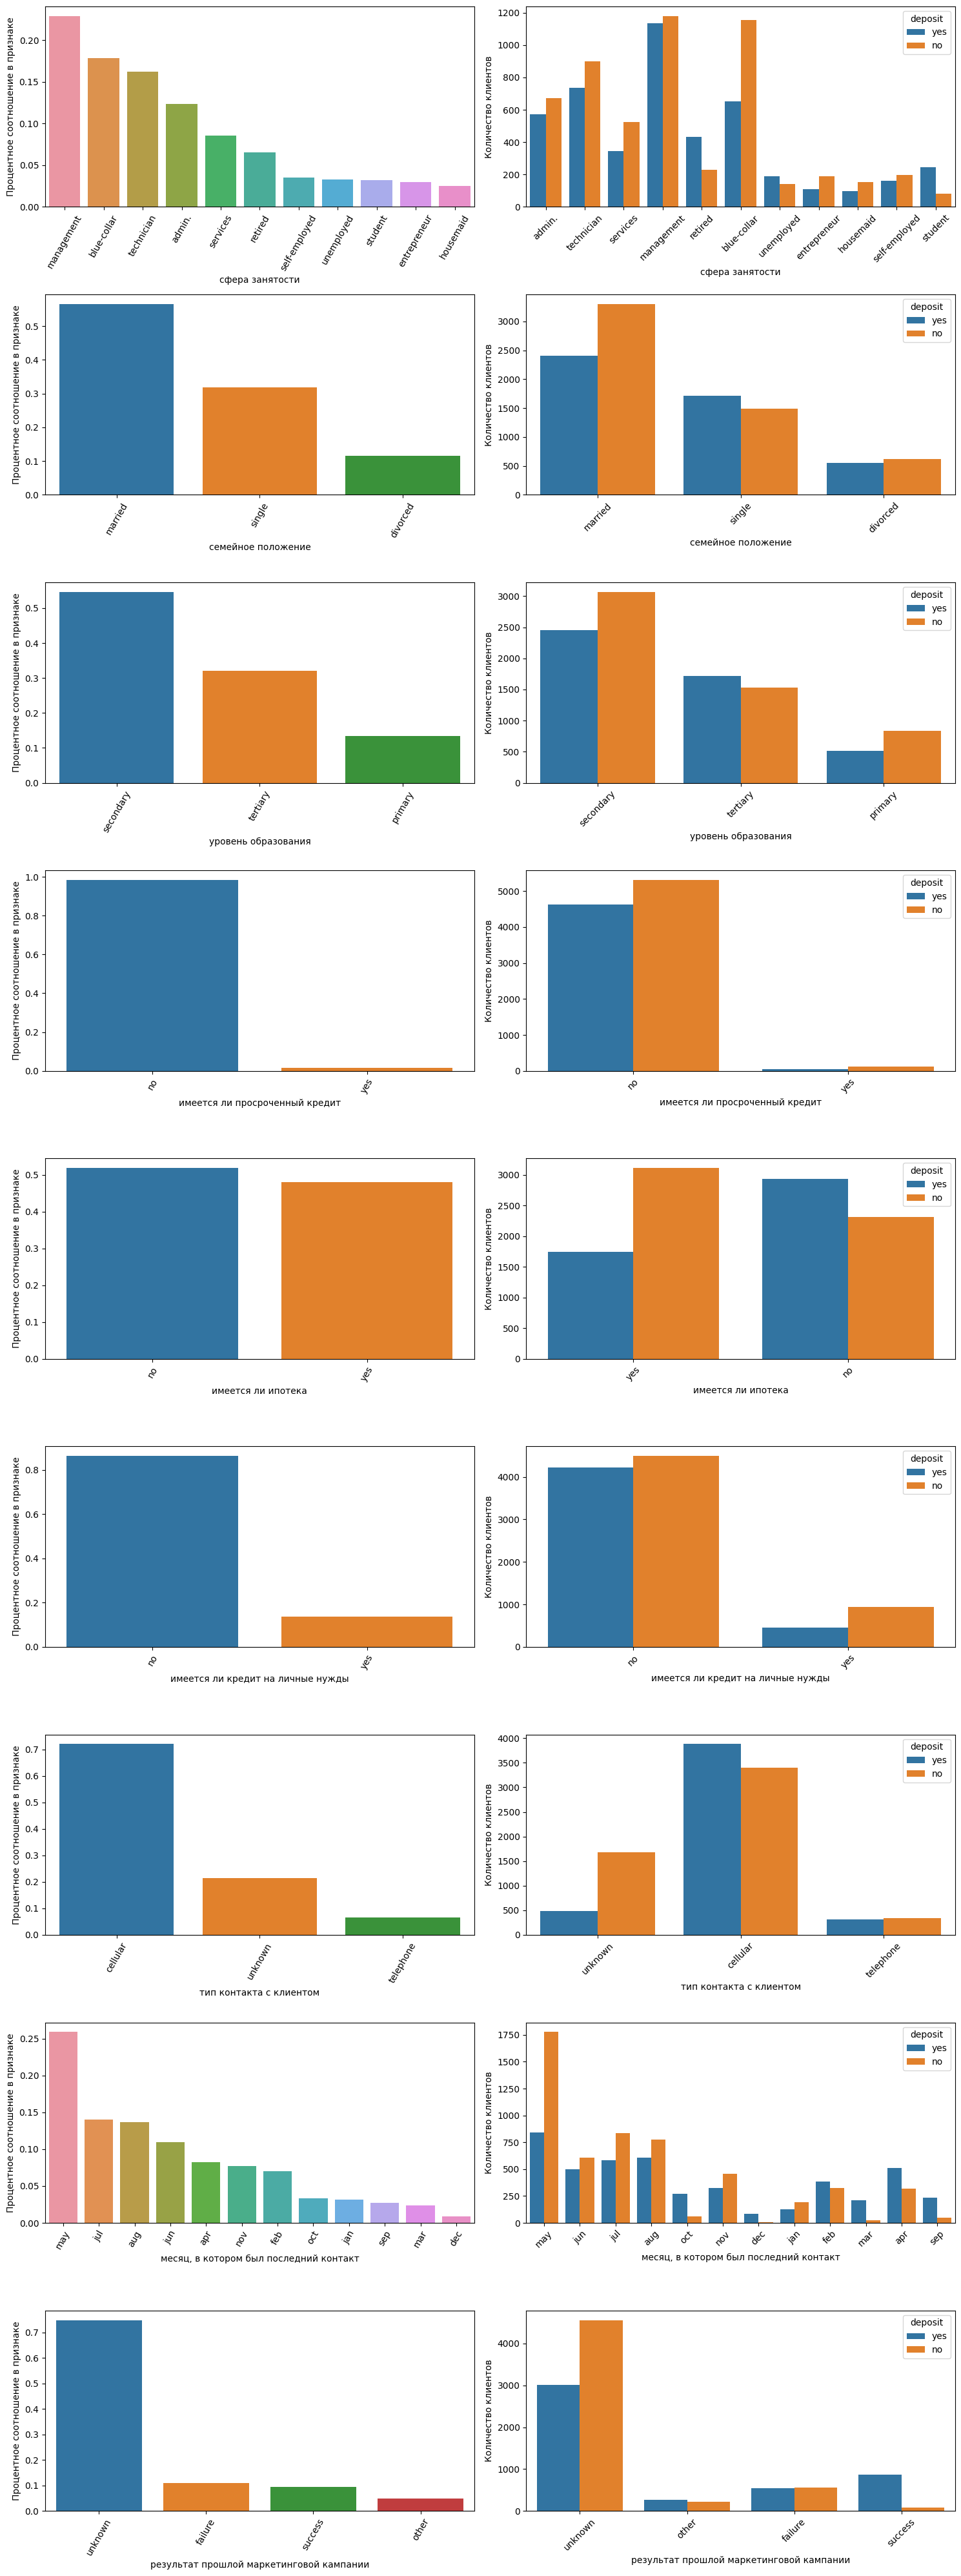

In [521]:
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(categorial):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в признаке
    count_data = (cleaned_df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    #Строим столбчатую диаграмму где отобразим долевое соотношение каждой из категорий в признаке
    part_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    #повернём подписи на 45 градусов для удобочитаемости
    part_barplot.xaxis.set_tick_params(rotation=60)
    #подпишем каждый график по оси Х (берём данные из словаря) и Y
    part_barplot.set(xlabel=categorial_name[feature], ylabel="Процентное соотношение в признаке")
    #Строим столбчатую диаграмму количества клиентов в разрезе согласия на депозит по каждому признаку
    count_barplot = sns.countplot(data=cleaned_df, x=feature, hue='deposit', ax=axes[i][1])
    #повернём подписи на 45 градусов для удобочитаемости
    count_barplot.xaxis.set_tick_params(rotation=45)
    #подпишем каждый график по оси Х (берём данные из словаря) и Y
    count_barplot.set(xlabel=categorial_name[feature], ylabel="Количество клиентов")
plt.tight_layout() #выравнивание графиков

### Задание 6

In [522]:
#Построим многоуровневую столбчатую диаграмму
fig_poutcome = px.histogram(cleaned_df, 
        x="poutcome", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Количество клиентов учавствовавших в прошлых компаниях и в текущей', 
        labels=dict(poutcome='Название предыдущей компании', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_poutcome.update_layout(yaxis_title_text='Количество клиентов')
fig_poutcome.show()

### Задание 7

In [523]:
#Построим многоуровневую столбчатую диаграмму
fig_month = px.histogram(cleaned_df, 
        x="month", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Количество клиентов учавствовавших в прошлых компаниях и в текущей', 
        labels=dict(month='Название месяца', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_month.update_layout(yaxis_title_text='Количество клиентов')
fig_month.show()

### Задание 8

In [524]:
#Создадим словарь, где определим новые категории для признака age
age_category = {30:'<30',40:'30-40',50:'40-50',60:'50-60'}

#Создадим функцию преобразования признака age
def change_age (age):
    #перебираем словарь и если возраст меньше какого-либо ключа, то присваиваем его значение
    for i,j in age_category.items():
        if age < i: return j
    #если не один ключ не подошёл, то относим человека к категории '60+'
    return '60+'

#создадим новый признак age_category
cleaned_df ['age_category']=cleaned_df.age.apply(change_age)

#Построим многоуровневую столбчатую диаграмму
fig_age = px.histogram(cleaned_df, 
        x="age_category", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Количество клиентов учавствовавших в прошлых компаниях и в текущей', 
        labels=dict(age_category='Название категории', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_age.update_layout(yaxis_title_text='Количество клиентов')
fig_age.show()

### Задания 9 и 10

In [525]:
#Построим многоуровневую столбчатую диаграмму
fig_job = px.histogram(cleaned_df, 
        x="job", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Распределение клиентво по сфере занятости', 
        labels=dict(job='Сфера занятости клиента', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_job.update_layout(yaxis_title_text='Количество клиентов')
fig_job.show()

> По полученным графикам видно, что большая часть клиентов банка работает в сфере management, что не удивительно, ведь это наиболее распостранённая сфера. Меньше всего клиентов в сфере housemaid. так же стоит отметить, что клиенты сферы student в три раза чаще соглашаются открыть депозит, чем отказываются от него. К тем кто чаще соглашается открыть депозит, чем отказываются от него так же относятся retired (пенсионеры) и unemployed (безработные).

In [526]:
#Построим многоуровневую столбчатую диаграмму
fig_marital = px.histogram(cleaned_df, 
        x="marital", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Распределение клиентво по семейному положению', 
        labels=dict(job='Сфера занятости клиента', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_marital.update_layout(yaxis_title_text='Количество клиентов')
fig_marital.show()

> по полученному графику видно, что чаще на депозит соглашаются неженатые люди. А вот женатые, наоборот, чаще отказываются от открытия депозита.

In [527]:
#Построим многоуровневую столбчатую диаграмму
fig_education = px.histogram(cleaned_df, 
        x="education", 
        y="deposit", 
        histfunc='count', 
        color="deposit", 
        barmode='group',
        text_auto=True,
        width=800,
        title='Распределение клиентов по уровню образования', 
        labels=dict(education='Уровень образования', deposit='Согласился ли на депозит')
        )
#Переименуем ось Y
fig_education.update_layout(yaxis_title_text='Количество клиентов')
fig_education.show()

> По полученному графику видно, что чаще всего на депозит соглашаются люди с высшим образованием. Чаще всего отказываются люди с начвальным образованием.

### Задание 11

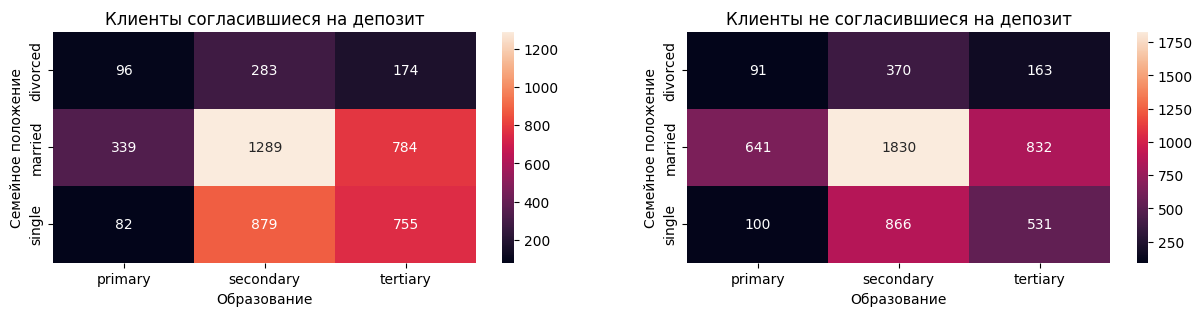

In [528]:
df_deposit_yes = cleaned_df[cleaned_df.deposit == 'yes']
combined_data_yes = df_deposit_yes.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

df_deposit_no = cleaned_df[cleaned_df.deposit == 'no']
combined_data_no = df_deposit_no.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

#add data to plots
sns.heatmap(data=combined_data_yes,ax=axs[0],annot=True,fmt=".0f")
axs[0].set_title("Клиенты согласившиеся на депозит")
axs[1].set_title("Клиенты не согласившиеся на депозит")
axs[0].set(xlabel="Образование", ylabel="Семейное положение")
sns.heatmap(data=combined_data_no,ax=axs[1],annot=True,fmt=".0f")
axs[1].set(xlabel="Образование", ylabel="Семейное положение");

## Часть 3: преобразование данных

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

- Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.
- Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
- Надо отобрать признаки, которые мы будем использовать для обучения модели.

### Задание 1

In [529]:
#определим кодировщик
le = LabelEncoder()
#перекожируем признак education
cleaned_df.education = le.fit_transform(cleaned_df['education'])
print (f'Сумма получившихся значений для признака education {cleaned_df.education.sum()}')

#Перекодируем признак age_category по тому же принципу
cleaned_df.age_category = le.fit_transform(cleaned_df['age_category'])

Сумма получившихся значений для признака education 11995


### Задания 2 и 3

In [530]:
#Перекодируем признаки deposit, default, housing, loan по тому же принципу
cleaned_df['deposit'] = le.fit_transform(cleaned_df['deposit'])
cleaned_df['default'] = le.fit_transform(cleaned_df['default'])
cleaned_df['housing'] = le.fit_transform(cleaned_df['housing'])
cleaned_df['loan'] = le.fit_transform(cleaned_df['loan'])
#Посчитаем показатели
print(cleaned_df.deposit.std())
print(round(cleaned_df.default.mean()+cleaned_df.housing.mean()+cleaned_df.loan.mean(),3))

0.4986712532452124
0.635


### Задание 4

In [531]:
cleaned_df_dummies = pd.get_dummies(cleaned_df, columns=['job', 'marital', 'contact', 'month','poutcome'])
cleaned_df_dummies

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

In [532]:
corr = cleaned_df_dummies.corr()
corr.style.background_gradient()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,age_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,0.025383,0.024357,0.122622,-0.057502,-0.065917,0.028390,0.092661,-0.036163,0.545524,-0.027947,-0.077266,-0.231436,-0.074596,0.001263,0.185312,0.316681,-0.464737,-0.074062,0.194455,-0.036224,-0.026208,0.060980,0.031151,0.014729,0.017477,-0.003662,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,0.025368,0.098253,-0.099057,-0.055817,-0.371796,0.024219,-0.144242,0.518735,-0.148800,0.091001,-0.103846,-0.009494,0.047966,-0.031813,-0.033425,-0.133514,0.165140,0.172697,-0.080767,-0.140256,0.015456,0.102218,0.004171,0.036743,-0.002330,-0.049832,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,-0.036605,-0.038872,0.002058,-0.022421,0.022989,0.023264,0.019273,-0.000055,-0.018524,0.008924,-0.020168,-0.019190,0.004419,0.011120,0.021028,-0.007670,-0.006322,-0.028878,-0.021596,0.044621,-0.018812,-0.003966,-0.012456,-0.020260,0.003382,0.048653,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,0.060419,0.135893,0.027820,-0.028057,-0.049484,-0.008727,0.000907,0.039205,0.091421,0.009889,-0.037633,0.007133,-0.010460,0.009689,-0.030406,0.032056,-0.013176,0.030039,0.061140,-0.069737,0.050392,-0.008252,0.027092,0.010160,-0.011331,-0.086824,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,-0.000221,-0.200290,-0.153188,0.063547,0.194115,0.006600,-0.063824,-0.077697,-0.168785,-0.019555,0.080129,-0.124261,0.004772,-0.059712,0.009686,0.036857,-0.045904,-0.186832,-0.084942,0.255649,0.031485,-0.235772,-0.059625,-0.079198,-0.090039,-0.029806,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,-0.020087,-0.107240,-0.028775,0.049098,0.056857,0.038298,-0.028973,-0.052683,-0.045674,0.004113,0.032109,-0.071385,0.009501,-0.039883,0.028408,0.044692,-0.067140,0.000653,-0.016394,0.009172,-0.040164,-0.064208,-0.029521,-0.012067,0.003325,0.163249,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,-0.059739,-0.056878,-0.007096,-0.010680,-0.019876,-0.005463,0.010920,0.003025,-0.005226,0.001565,0.002787,-0.010712,0.031050,-0.001380,0.003626,0.001760,-0.004371,-0.006511,0.013647,-0.001105,0.110547,-0.001758,-0.011651,-0.236222,0.225136,0.130897,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,-0.034233,0.457818,0.002826,-0.023585,0.032253,0.000594,-0.010009,-0.024309,0.006052,0.014513,0.013911,-0.017974,-0.007488,0.027641,0.023425,-0.037747,0.024042,0.022006,-0.022244,-0.010665,0.027398,-0.024372,0.007100,-0.025231,-0.010272,0.

> В такой таблице сложно что-то поределеить. Выведем пять признаков наиболее коррелирующих с признаком deposit

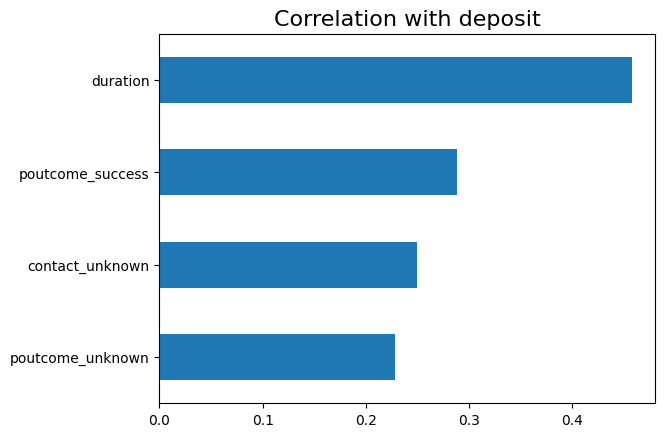

In [551]:
#На основе признака deposit отбираем значения по модулю (т.к. нам не важно прямая или обратная зависимость),
#сортирируем их в порядке возрастания и выводим 5 значений с конца (наибольших).
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задания 7 и 8

In [533]:
X = cleaned_df_dummies.drop(['deposit'], axis=1)
y = cleaned_df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print (f'Размер тестовой выборки: {X_test.shape}')
print (f'Cреднее значение целевой переменной на тестовой выборке {round(y_test.mean(),2)}')

Размер тестовой выборки: (3335, 45)
Cреднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [534]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector_SKB = SelectKBest(score_func=f_classif, k=15)
selector_SKB.fit(X_train, y_train)
X_train_new=X_train[selector_SKB.get_feature_names_out()]
X_test_new=X_test[selector_SKB.get_feature_names_out()]

print(F'Наиболее значимые признаки по методу SelectKBest: {selector_SKB.get_feature_names_out()}')

Наиболее значимые признаки по методу SelectKBest: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [535]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train_new)
#кодируем датасеты 
X_train_scaled = mm_scaler.transform(X_train_new)
X_test_scaled = mm_scaler.transform(X_test_new)

print(f'Cреднее арифметическое для первого предиктора: {round(X_test_scaled[:, 0].mean(),2)}')

Cреднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

### Задание 1

In [536]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000)
#Обучаем модель
log_reg.fit(X_train_scaled, y_train)
#получаем предсказания модели
y_train_pred_log_reg = log_reg.predict(X_train_scaled)
y_test_pred_log_reg = log_reg.predict(X_test_scaled)
#Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy на тренировочной выборке: 0.82
Accuracy на тестовой выборке: 0.80


### Задания 2,3,4

In [537]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
d_tree = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений
d_tree.fit(X_train_scaled, y_train)
y_train_pred_d_tree = d_tree.predict(X_train_scaled)
y_test_pred_d_tree = d_tree.predict(X_test_scaled)

#Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_d_tree)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_d_tree)))


Accuracy на тренировочной выборке: 1.00
Accuracy на тестовой выборке: 0.75


In [538]:
#добавим параметр max_depth и побдерём для него значение, где Accuracy на тестовой выборке будет максимальным

#Создаём объект класса DecisionTreeClassifier
d_tree = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42,
    max_depth=7
)
#Обучаем дерево решений
d_tree.fit(X_train_scaled, y_train)
y_train_pred_d_tree = d_tree.predict(X_train_scaled)
y_test_pred_d_tree = d_tree.predict(X_test_scaled)

#Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_d_tree)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_d_tree)))

Accuracy на тренировочной выборке: 0.84
Accuracy на тестовой выборке: 0.82


### Задание 5

In [539]:
#задаём сетку гиперпараметров, из которых будем отбирать лучшие
param_grid = {'min_samples_split': [2, 5, 7, 10], #минимальное число объектов в листе
              'max_depth': [3,5,7], #максимальная глубина дерева
              }
#устанавливаем параметры для GridSearchCV
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
                criterion='entropy', #критерий информативности
                random_state=42
                ), 
    param_grid=param_grid, 
    cv=3, #ограничиваем количество фолдов 3
    n_jobs = -1, 
    scoring='f1' #задаём метрику
    )  
grid_search.fit(X_train, y_train) 
print("f1_score на тренировочной выборке: {:.2f}".format(grid_search.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

f1_score на тренировочной выборке: 0.81
f1_score на тестовой выборке: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}
Наилучшее значение точности при кросс-валидаци: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [540]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(n_estimators = 100,
            criterion = 'gini', #критерий информативности
            min_samples_leaf = 5, #минимальное число объектов в листе
            max_depth = 10, #макисмальная глубина дерева
            random_state = 42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

#Рассчитываем accuracy и Recall
print('Показатели на тренировочной выборке:')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_rf)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred_rf)))
print('Показатели на тестовой выборке:')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_rf)))


Показатели на тренировочной выборке:
Accuracy: 0.86
Recall: 0.86
Показатели на тестовой выборке:
Accuracy: 0.83
Recall: 0.83


### Задания 2 и 3

In [541]:
# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05, #темп обучения
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf = 5, #минимальное число объектов в листе 
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказания
y_train_pred_gb = gb.predict(X_train_scaled)
y_test_pred_gb = gb.predict(X_test_scaled)
# Посмотрим на метрику f1
print("f1_score на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred_gb)))
print("f1_score на тестовой выборке: {:.2f}".format(metrics.f1_score(y_test, y_test_pred_gb)))


f1_score на тренировочной выборке: 0.88
f1_score на тестовой выборке: 0.82


### Задание 4

In [542]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('d_tree', tree.DecisionTreeClassifier(
                criterion='entropy', #критерий информативности
                min_samples_leaf=5, #минимальное число объектов в листе 
                max_depth=6, #максимальная глубина дерева
                random_state=42)),
    ('log_reg', linear_model.LogisticRegression(
                solver='sag', 
                random_state=42, 
                max_iter=1000)), 
    ('gb', ensemble.GradientBoostingClassifier(
                learning_rate = 0.05, #темп обучения
                max_depth=5, #максимальная глубина дерева
                min_samples_leaf = 5, #минимальное число объектов в листе 
                n_estimators=300, #количество деревьев в ансамбле
                random_state=42))     
    ]
# Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

#Обучаем модель
stack.fit(X_train_scaled, y_train)
# Формируем предсказания
y_train_pred_stack = stack.predict(X_train_scaled)
y_test_pred_stack = stack.predict(X_test_scaled)

# Посмотрим на метрику precision
print("precision на тренировочной выборке: {:.2f}".format(metrics.precision_score(y_train, y_train_pred_stack)))
print("precision на тестовой выборке: {:.2f}".format(metrics.precision_score(y_test, y_test_pred_stack)))

precision на тренировочной выборке: 0.86
precision на тестовой выборке: 0.81


### Задание 5

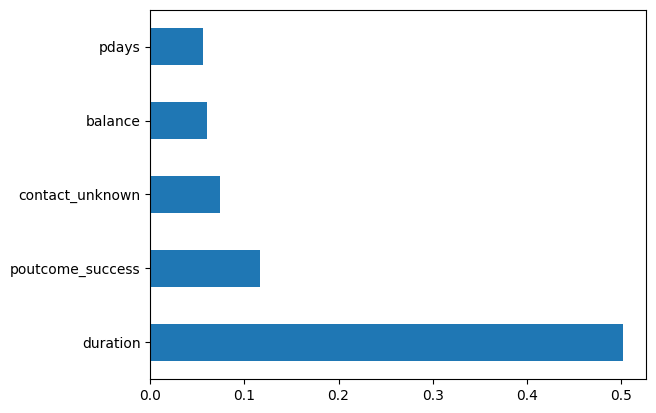

In [543]:
#Посмотрим какие 5 признаков сильнее влияют на модель градиентного бустинга
feat_importances = pd.Series(gb.feature_importances_, index=X_train_new.columns)
#Построим многоуровневую столбчатую диаграмму
feat_importances.nlargest(5).plot(kind='barh');

### Задания 6,7,8

In [544]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score  

In [545]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-12 12:44:43,648] A new study created in memory with name: RandomForestClassifier
[I 2023-05-12 12:44:44,567] Trial 0 finished with value: 0.8529871754770098 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8529871754770098.
[I 2023-05-12 12:44:45,693] Trial 1 finished with value: 0.8665938523950694 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8665938523950694.
[I 2023-05-12 12:44:46,573] Trial 2 finished with value: 0.849890316515199 and parameters: {'n_estimators': 163, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8665938523950694.
[I 2023-05-12 12:44:47,279] Trial 3 finished with value: 0.8695652173913044 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8695652173913044.
[I 2023-05-12 12:44:48,371] Trial 4 finished with value: 0.8688857634005315 and parameters: {'n_e

In [546]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score тренировочной выборке: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score тренировочной выборке: 0.92


In [547]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
# Формируем предсказания
y_train_pred_optima= stack.predict(X_train_scaled)
y_test_pred_optima = stack.predict(X_test_scaled)
#Рассчитываем метрики
print('Показатели на тренировочной выборке:')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_optima)))
print("f1_score: {:.2f}".format(model.score(X_train_scaled, y_train)))
print('Показатели на тестовой выборке:')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_optima)))
print("f1_score: {:.2f}".format(model.score(X_test_scaled, y_test)))


Показатели на тренировочной выборке:
Accuracy: 0.87
f1_score: 0.93
Показатели на тестовой выборке:
Accuracy: 0.82
f1_score: 0.83


In [548]:
#сравнительная таблица полученных результатов по метрикам
